# Fourier Series, Fourier Transform, Laplace Transform, the *s*-plane — and the Digital Counterparts (*z*-plane, Z-transform, DFT/FFT)
**Audience:** students learning signals & systems (analog → digital).  
**Style:** complex notation throughout; lots of pictures and small numeric examples.

---

## Learning goals
By the end of this notebook you should be able to:

1. Explain what each transform “assumes” about the signal (periodic vs aperiodic; continuous vs discrete; stable/causal vs not).
2. Interpret the **complex plane** pictures:
   - **Analog:** the *s*-plane (Laplace) and the **jΩ axis** (Fourier).
   - **Digital:** the *z*-plane (Z-transform) and the **unit circle** (DFT/DTFT).
3. See (numerically) that:
   - **Convolution in time** ↔ **multiplication in frequency**
   - **DFT** is the **Z-transform evaluated on the unit circle** at equally spaced angles
   - **FFT** is just a *fast algorithm* for the DFT exploiting symmetries and divide-and-conquer.

> Convention note: different textbooks use different sign conventions. We’ll use the common EE convention:
> - Fourier transform: \(X(\Omega) = \int x(t)e^{-j\Omega t}\,dt\)
> - DTFT: \(X(e^{j\omega}) = \sum x[n]e^{-j\omega n}\)
> - DFT: \(X[k] = \sum_{n=0}^{N-1} x[n]e^{-j 2\pi kn/N}\)


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
rng = np.random.default_rng(0)

# Helper: nicer plots
def stem(ax, n, x, **kwargs):
    ax.vlines(n, 0, x, **kwargs)
    ax.plot(n, x, 'o', **kwargs)


## 1) Complex numbers and the complex plane
We will use complex exponentials to represent sinusoids and to define transforms.

### Complex exponential and Euler’s formula
\[
e^{j\theta} = \cos(\theta) + j\sin(\theta)
\]

- Magnitude: \(|e^{j\theta}| = 1\)
- Angle: \(\arg(e^{j\theta}) = \theta\)

### General complex plane
A complex number can be written:
\[
z = a + jb
\]
and also in polar form:
\[
z = re^{j\theta}
\]

---

## 2) The analog **s-plane**
For continuous-time signals, the **Laplace** variable is:
\[
s = \sigma + j\Omega
\]

- \(\sigma\) controls **exponential growth/decay**
- \(\Omega\) controls **oscillation frequency**
- The **jΩ axis** is the vertical axis where \(\sigma=0\).

A key connection:
- **Fourier Transform** corresponds to evaluating the Laplace transform on the **jΩ axis** (when it exists).


<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
/var/folders/yj/6sjdgxm52t5d_p4w0lcrsrzr0000gp/T/ipykernel_96493/1647969088.py:7: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title("Analog s-plane: $s = \sigma + j\Omega$")


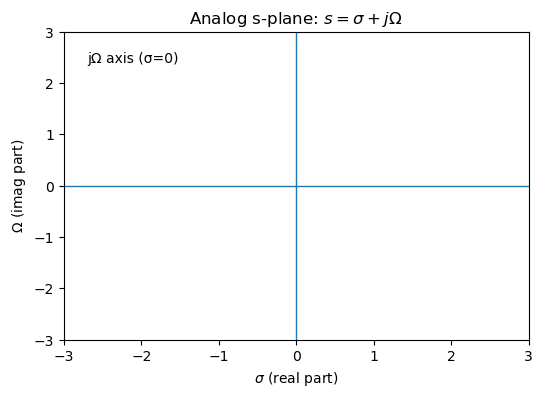

In [2]:
# Visualize the s-plane and the jΩ axis
fig, ax = plt.subplots(figsize=(6,4))
ax.axhline(0, linewidth=1)
ax.axvline(0, linewidth=1)
ax.set_xlabel(r"$\sigma$ (real part)")
ax.set_ylabel(r"$\Omega$ (imag part)")
ax.set_title("Analog s-plane: $s = \sigma + j\Omega$")
ax.text(0.05, 0.9, "jΩ axis (σ=0)", transform=ax.transAxes)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
plt.show()


## 3) Fourier Series (FS): periodic signals
### When do we use it?
- Use **Fourier Series** when \(x(t)\) is **periodic** with period \(T_0\).

### Complex Fourier Series
\[
x(t) = \sum_{k=-\infty}^{\infty} c_k e^{jk\Omega_0 t}, \quad \Omega_0 = \frac{2\pi}{T_0}
\]
where
\[
c_k = \frac{1}{T_0}\int_{t_0}^{t_0+T_0} x(t)\,e^{-jk\Omega_0 t}\,dt
\]

**Interpretation:**
- \(x(t)\) is built from discrete frequencies at \(k\Omega_0\)
- \(c_k\) are complex amplitudes (magnitude + phase)

---

### Example: a periodic square wave (numerical Fourier Series coefficients)
We’ll approximate the Fourier series coefficients by sampling one period densely.


/var/folders/yj/6sjdgxm52t5d_p4w0lcrsrzr0000gp/T/ipykernel_96493/626494759.py:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ck_k = (1/T0) * np.trapz(x * np.exp(-1j*k*Omega0*t), t)


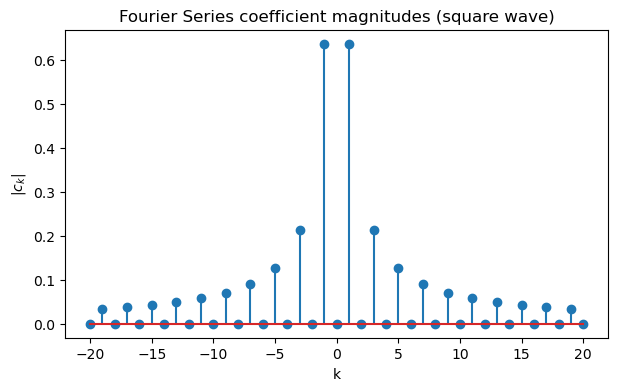

In [3]:
# Periodic square wave over one period
T0 = 2.0
Omega0 = 2*np.pi/T0

# Dense time grid over one period
t = np.linspace(0, T0, 5000, endpoint=False)
x = np.where(t < T0/2, 1.0, -1.0)  # 50% duty square wave

# Compute c_k numerically for a range of k
K = 20
ck = []
ks = np.arange(-K, K+1)
for k in ks:
    ck_k = (1/T0) * np.trapz(x * np.exp(-1j*k*Omega0*t), t)
    ck.append(ck_k)
ck = np.array(ck)

# Plot magnitude of coefficients
fig, ax = plt.subplots(figsize=(7,4))
ax.stem(ks, np.abs(ck))
ax.set_xlabel("k")
ax.set_ylabel(r"$|c_k|$")
ax.set_title("Fourier Series coefficient magnitudes (square wave)")
plt.show()


## 4) Fourier Transform (FT): aperiodic signals
### When do we use it?
- Use the **Fourier Transform** for **aperiodic** continuous-time signals.

\[
X(\Omega)=\int_{-\infty}^{\infty}x(t)e^{-j\Omega t}\,dt
\]
\[
x(t)=\frac{1}{2\pi}\int_{-\infty}^{\infty}X(\Omega)e^{j\Omega t}\,d\Omega
\]

**Interpretation:**
- Now frequency is **continuous** (not just harmonics).
- \(X(\Omega)\) tells you “how much” of each frequency is present.

---

### Connection FS ↔ FT (conceptual)
A common viewpoint:
- A periodic signal has a **line spectrum** (discrete frequencies).
- As period \(T_0 \to \infty\), those lines get closer and (with scaling) approach a continuous spectrum.

---

### Example: Gaussian pulse (its Fourier transform is also Gaussian)
We’ll show the magnitude spectrum numerically via FFT on a long window.


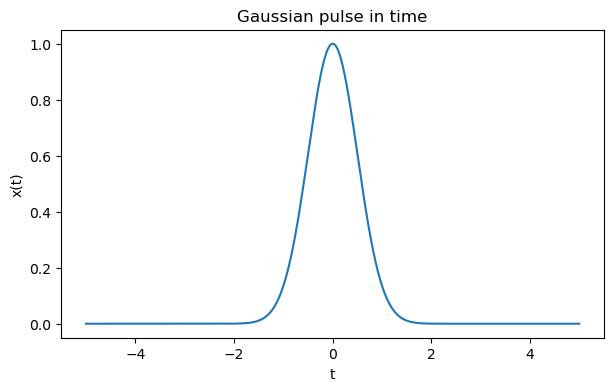

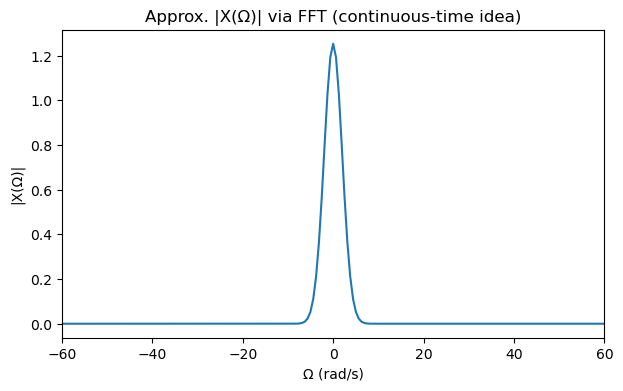

In [4]:
# Gaussian pulse in time
t = np.linspace(-5, 5, 4096, endpoint=False)
dt = t[1]-t[0]
sigma_t = 0.5
x = np.exp(-(t**2)/(2*sigma_t**2))

# Compute approximate Fourier transform via FFT (frequency axis in rad/s)
X = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(x))) * dt  # scale for integral approx
omega = np.fft.fftshift(np.fft.fftfreq(len(t), d=dt)) * 2*np.pi

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(t, x)
ax.set_title("Gaussian pulse in time")
ax.set_xlabel("t")
ax.set_ylabel("x(t)")
plt.show()

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(omega, np.abs(X))
ax.set_title("Approx. |X(Ω)| via FFT (continuous-time idea)")
ax.set_xlabel("Ω (rad/s)")
ax.set_ylabel("|X(Ω)|")
ax.set_xlim(-60, 60)
plt.show()


## 5) Laplace Transform: adding exponential growth/decay
### Why Laplace?
Fourier transform can fail to exist for signals that don’t “behave” well (don’t decay fast enough).  
The Laplace transform generalizes Fourier by allowing exponential weighting.

\[
X(s)=\int_{-\infty}^{\infty}x(t)e^{-st}\,dt,\quad s=\sigma+j\Omega
\]

If you set \(\sigma=0\) (i.e., \(s=j\Omega\)), you recover the Fourier transform **when the integral converges**:
\[
X(j\Omega)=\int x(t)e^{-j\Omega t}\,dt
\]

### Region of Convergence (ROC)
The Laplace transform exists only for values of \(s\) where the integral converges.  
The set of those \(s\) values is the **ROC**.

### Poles and zeros, and why the s-plane matters
For LTI systems, the transfer function \(H(s)\) often becomes a rational function:
\[
H(s) = \frac{N(s)}{D(s)}
\]
- **Poles**: roots of \(D(s)\)
- **Zeros**: roots of \(N(s)\)

**Stability (continuous-time):**
- A causal LTI system is BIBO-stable if **all poles are in the left half-plane** (\(\Re\{s\}<0\)).

---

### Example: first-order low-pass filter
\[
H(s)=\frac{1}{1+s/\omega_c}=\frac{\omega_c}{s+\omega_c}
\]
Pole at \(s=-\omega_c\) (stable).


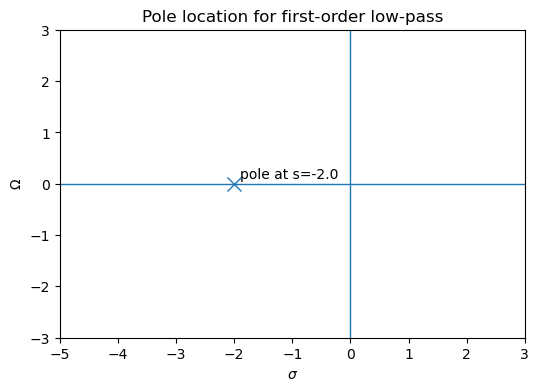

In [5]:
# Plot a simple pole in the s-plane for a first-order low-pass
omega_c = 2.0
pole = -omega_c + 0j

fig, ax = plt.subplots(figsize=(6,4))
ax.axhline(0, linewidth=1)
ax.axvline(0, linewidth=1)
ax.plot(np.real(pole), np.imag(pole), 'x', markersize=10)
ax.text(np.real(pole)+0.1, np.imag(pole)+0.1, f"pole at s={pole.real:.1f}")
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel(r"$\Omega$")
ax.set_title("Pole location for first-order low-pass")
ax.set_xlim(-5, 3)
ax.set_ylim(-3, 3)
plt.show()


## 6) Moving to **digital** signals
Digital (discrete-time) signals are sequences \(x[n]\) sampled at some rate \(f_s\).

- Time index \(n\) is integer.
- Frequency becomes **digital angular frequency** \(\omega\) (radians/sample).

The complex variable used in the Z-transform is:
\[
z = re^{j\omega}
\]
This lives in the **z-plane**.

Key parallels:
- Analog: \(s = \sigma + j\Omega\)
- Digital: \(z = re^{j\omega}\)

---

## 7) The z-plane
- Radius \(r\) controls exponential growth/decay in \(n\)
- Angle \(\omega\) controls oscillation frequency

The **unit circle** is \(r=1\). That’s where the DTFT lives.


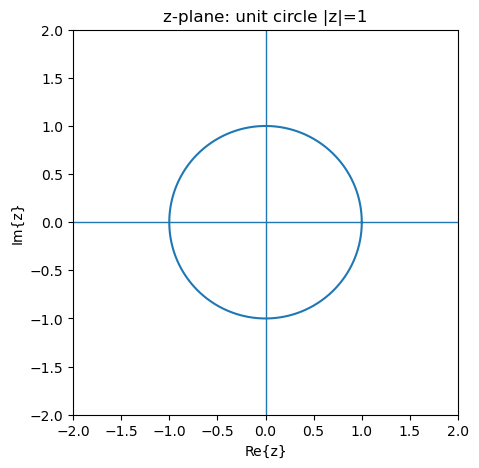

In [6]:
# Visualize the z-plane and the unit circle
theta = np.linspace(0, 2*np.pi, 400)
unit_x = np.cos(theta)
unit_y = np.sin(theta)

fig, ax = plt.subplots(figsize=(5,5))
ax.axhline(0, linewidth=1)
ax.axvline(0, linewidth=1)
ax.plot(unit_x, unit_y)
ax.set_aspect('equal', 'box')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_title("z-plane: unit circle |z|=1")
ax.set_xlabel("Re{z}")
ax.set_ylabel("Im{z}")
plt.show()


## 8) Z-transform: discrete-time cousin of Laplace
\[
X(z)=\sum_{n=-\infty}^{\infty} x[n] z^{-n}
\]

- Exists for \(z\) in some **ROC** (region of convergence), typically an annulus \(r_1<|z|<r_2\).
- For LTI systems, transfer function is often rational:
\[
H(z)=\frac{B(z)}{A(z)}
\]
- **Poles/zeros** in the z-plane govern stability and frequency response.

**Stability (discrete-time):**
- A causal LTI system is BIBO-stable if **all poles are inside the unit circle** \(|z|<1\).

---

## 9) DTFT: Z-transform evaluated on the unit circle
If the ROC includes the unit circle, then:
\[
X(e^{j\omega}) = X(z)\big|_{z=e^{j\omega}}
\]
That is: **DTFT is the Z-transform on the unit circle**.

---

## 10) DFT: sampling the DTFT at N equally spaced frequencies
For a length-\(N\) sequence \(x[n]\):
\[
X[k] = \sum_{n=0}^{N-1} x[n] e^{-j2\pi kn/N}
\]
This is just the DTFT evaluated at \(\omega_k=2\pi k/N\), assuming periodic extension.

---

### DFT as Z-transform evaluated on the unit circle
Take the Z-transform:
\[
X(z)=\sum_{n=0}^{N-1} x[n] z^{-n}
\]
Evaluate at:
\[
z_k = e^{j2\pi k/N}
\]
Then:
\[
X(z_k) = \sum_{n=0}^{N-1} x[n] e^{-j2\pi kn/N} = X[k]
\]

So:
> **DFT = Z-transform evaluated on the unit circle at equally spaced points.**


In [7]:
# Demonstrate: DFT equals Z-transform evaluated at unit-circle roots of unity
N = 16
n = np.arange(N)
x = np.cos(2*np.pi*3*n/N) + 0.5*np.sin(2*np.pi*5*n/N)  # a simple discrete signal

# DFT via numpy
X_dft = np.fft.fft(x)

# "Z-transform evaluation" on unit circle points z_k = exp(j2πk/N)
k = np.arange(N)
z_k = np.exp(1j*2*np.pi*k/N)
X_z = np.array([np.sum(x * (zk**(-n))) for zk in z_k])

# Compare
max_err = np.max(np.abs(X_dft - X_z))
max_err


np.float64(1.5727593509286903e-14)

If everything is consistent, the maximum error should be ~ numerical precision (≈ 1e-12 or so).

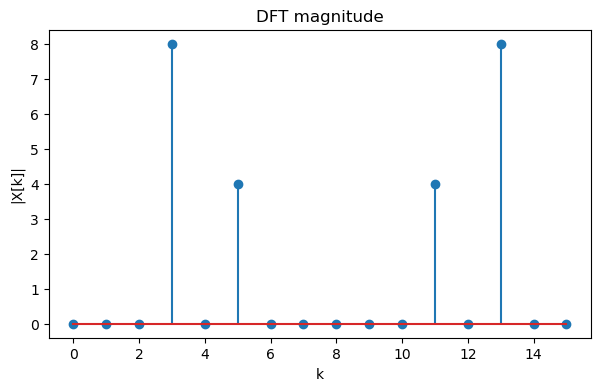

In [8]:
# Plot magnitude spectra
fig, ax = plt.subplots(figsize=(7,4))
ax.stem(np.arange(N), np.abs(X_dft))
ax.set_xlabel("k")
ax.set_ylabel("|X[k]|")
ax.set_title("DFT magnitude")
plt.show()


## 11) Convolution (time domain) and multiplication (frequency domain)
### Continuous-time convolution
\[
(y = x * h)(t) = \int_{-\infty}^{\infty} x(\tau)\,h(t-\tau)\,d\tau
\]

### Discrete-time convolution
\[
(y = x * h)[n] = \sum_{m=-\infty}^{\infty} x[m]\,h[n-m]
\]

**Interpretation:** sliding, weighted sum.  
- \(h\) is often an impulse response of an LTI system.
- Convolution is how an LTI system maps input → output.

---

## 12) Convolution theorem
- Continuous-time:
  \[
  \mathcal{F}\{x*h\}=X(\Omega)H(\Omega)
  \]
- Discrete-time (DTFT):
  \[
  \text{DTFT}\{x*h\}=X(e^{j\omega})H(e^{j\omega})
  \]

### With the DFT (finite-length, periodic assumption)
Circular convolution in time ↔ pointwise multiplication in DFT bins:
\[
\text{DFT}\{x \circledast h\}=X[k]H[k]
\]
Linear convolution can be computed by DFT via **zero-padding** to avoid circular wrap-around.


### Example A: Linear convolution in time equals multiplication in frequency (with padding)
We’ll:
1. Pick two short sequences \(x[n]\) and \(h[n]\)
2. Compute linear convolution directly
3. Compute it again via DFT:
   - zero-pad to length \(N \ge L_x + L_h - 1\)
   - multiply DFTs
   - inverse DFT back to time


In [9]:
x = np.array([1, 2, 3, 2, 1], dtype=float)
h = np.array([1, -1, 0.5], dtype=float)

y_time = np.convolve(x, h, mode='full')

N = 1
while N < len(x) + len(h) - 1:
    N *= 2  # convenient power of two for FFT (not required for DFT)

X = np.fft.fft(x, N)
H = np.fft.fft(h, N)
Y = X * H
y_freq = np.fft.ifft(Y).real  # should be (close to) real

# Compare first L samples where L = len(x)+len(h)-1
L = len(x)+len(h)-1
err = np.max(np.abs(y_time - y_freq[:L]))

y_time, y_freq[:L], err


(array([1. , 1. , 1.5, 0. , 0.5, 0. , 0.5]),
 array([1.00000000e+00, 1.00000000e+00, 1.50000000e+00, 3.92523115e-17,
        5.00000000e-01, 0.00000000e+00, 5.00000000e-01]),
 np.float64(2.220446049250313e-16))

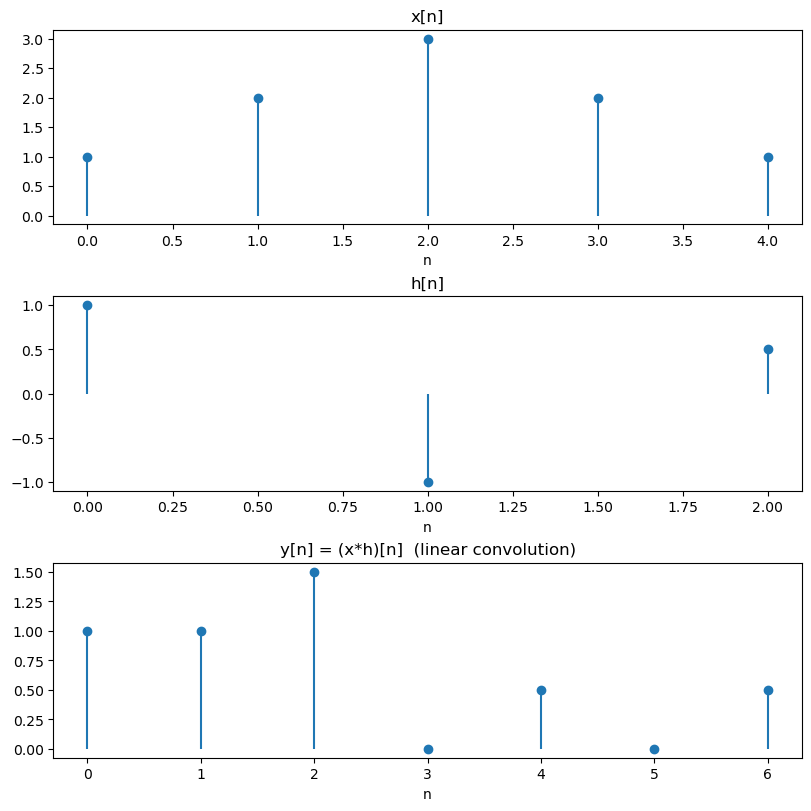

In [10]:
# Plot the sequences and results
fig, axes = plt.subplots(3, 1, figsize=(8, 8), constrained_layout=True)

n_x = np.arange(len(x))
n_h = np.arange(len(h))
n_y = np.arange(len(y_time))

stem(axes[0], n_x, x)
axes[0].set_title("x[n]")
axes[0].set_xlabel("n")

stem(axes[1], n_h, h)
axes[1].set_title("h[n]")
axes[1].set_xlabel("n")

stem(axes[2], n_y, y_time)
axes[2].set_title("y[n] = (x*h)[n]  (linear convolution)")
axes[2].set_xlabel("n")

plt.show()


### Example B: Circular convolution (what the DFT naturally computes)
If you don’t pad, DFT multiplication corresponds to **circular** convolution (wrap-around).

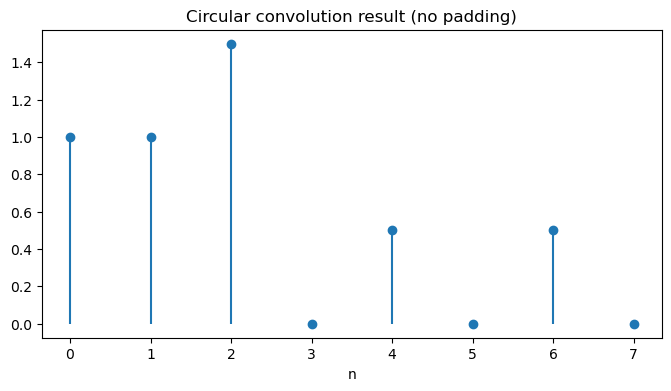

np.float64(2.220446049250313e-16)

In [11]:
N = 8  # intentionally too small (no padding)
X = np.fft.fft(x, N)
H = np.fft.fft(h, N)
y_circ = np.fft.ifft(X*H).real  # length N circular conv result

fig, ax = plt.subplots(figsize=(8,4))
stem(ax, np.arange(N), y_circ)
ax.set_title("Circular convolution result (no padding)")
ax.set_xlabel("n")
plt.show()

# Compare to linear conv truncated/wrapped to length N
y_lin = y_time
y_wrap = np.zeros(N)
for i, val in enumerate(y_lin):
    y_wrap[i % N] += val

np.max(np.abs(y_wrap - y_circ))


The match above illustrates: **DFT multiplication ↔ circular convolution**.  
To get **linear** convolution from FFTs/DFTs, pad to at least \(L_x+L_h-1\).

---

## 13) FFT: fast implementation of the DFT
The DFT definition is \(O(N^2)\) if computed directly.  
The **FFT** computes the same result in about \(O(N\log N)\) by exploiting:

- periodicity and symmetry of complex exponentials
- divide-and-conquer (e.g., radix-2 Cooley–Tukey factors N into smaller transforms)

**Key point:** FFT is not a different transform — it’s an algorithm for the DFT.

### Quick timing demo (optional)
We’ll compare a naive \(O(N^2)\) DFT with NumPy’s FFT for moderate N.


In [12]:
def dft_naive(x):
    x = np.asarray(x, dtype=complex)
    N = x.size
    n = np.arange(N)
    k = n.reshape((N, 1))
    W = np.exp(-1j * 2*np.pi * k * n / N)
    return W @ x

# Moderate size for demonstration (keep it small enough to run quickly)
N = 2^8192
x = rng.standard_normal(N)

# Time naive DFT
import time
t0 = time.perf_counter()
Xn = dft_naive(x)
t1 = time.perf_counter()

# Time FFT
t2 = time.perf_counter()
Xf = np.fft.fft(x)
t3 = time.perf_counter()

max_err = np.max(np.abs(Xn - Xf))
print(f'naive DFT time = {t1-t0}, FFT time = {t3-t2}, max error = {max_err}, speedup = {(t1-t0)/(t3-t2)}')



naive DFT time = 0.9228567089885473, FFT time = 0.0007622484117746353, max error = 7.323533865351184e-10, speedup = 1210.7033543566072


You should see:
- FFT time ≪ naive DFT time
- max error ~ numerical precision

---

## 14) Summary table
| Concept | Continuous-time (analog) | Discrete-time (digital) |
|---|---|---|
| Periodic representation | Fourier Series (FS) | Discrete-time Fourier Series (DTFS) (for periodic sequences) |
| Aperiodic frequency representation | Fourier Transform (FT) | DTFT (continuous frequency, discrete time) |
| Generalized transform for growth/decay | Laplace Transform (s-plane) | Z-transform (z-plane) |
| “Evaluate on special curve” | FT is Laplace on jΩ axis | DTFT is Z on unit circle |
| Sampled frequency bins | — | DFT (samples of DTFT) |
| Fast algorithm | — | FFT (fast DFT) |
| Time-domain LTI operation | Convolution integral | Convolution sum |
| Theorem | Convolution ↔ multiplication | Convolution ↔ multiplication (DTFT/DFT; circular unless padded) |

---

## 15) Practice questions
1. When does the Fourier transform fail to exist but Laplace can exist?
2. What does it mean for a discrete-time system to have a pole outside the unit circle?
3. Why does using an \(N\)-point DFT implicitly assume periodicity of \(x[n]\) with period \(N\)?
4. Why does “not padding” cause time-domain wrap-around in FFT-based filtering?
